<a href="https://colab.research.google.com/github/duanzhihua/-RAG-Excel/blob/main/dapotrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAPO: An Open-Source LLM Reinforcement Learning System at Scale

https://arxiv.org/abs/2503.14476


Inference scaling empowers LLMs with unprecedented reasoning ability, with reinforcement learning as the core technique to elicit complex reasoning. However, key technical details of state-of-the-art reasoning LLMs are concealed (such as in OpenAI o1 blog and DeepSeek R1 technical report), thus the community still struggles to reproduce their RL training results. We propose the Decoupled Clip and Dynamic sAmpling Policy Optimization (DAPO) algorithm, and fully open-source a state-of-the-art large-scale RL system that achieves 50 points on AIME 2024 using Qwen2.5-32B base model. Unlike previous works that withhold training details, we introduce four key techniques of our algorithm that make large-scale LLM RL a success. In addition, we open-source our training code, which is built on the verl framework, along with a carefully curated and processed dataset. These components of our open-source system enhance reproducibility and support future research in large-scale LLM RL.

<img src='https://arxiv.org/html/2503.14476v2/x1.png' width='600px' />


```python
# Copyright 2020-2025 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

```

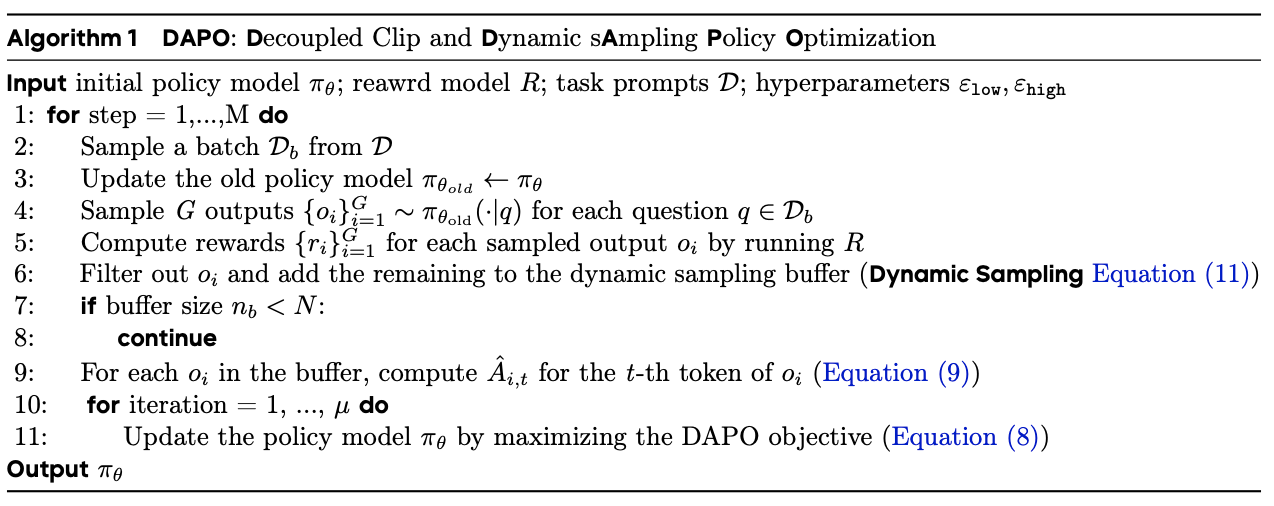

```python
import os
import textwrap
import warnings
from collections import defaultdict, deque
from collections.abc import Sized
from contextlib import nullcontext
from typing import Any, Callable, Optional, Union, List, Dict
from functools import update_wrapper, partial
import datasets
import torch
import torch.utils.data
import transformers
from accelerate.utils import (
    broadcast_object_list,
    gather,
    gather_object,
    is_peft_model,
    set_seed,
)
from datasets import Dataset, IterableDataset
from packaging import version
from torch import nn
from torch.utils.data import DataLoader, Sampler
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GenerationConfig,
    PreTrainedModel,
    PreTrainedTokenizerBase,
    Trainer,
    TrainerCallback,
    is_wandb_available,
)
from transformers.integrations.deepspeed import is_deepspeed_zero3_enabled
from transformers.trainer_utils import seed_worker
from transformers.utils import is_datasets_available, is_peft_available

from ..data_utils import (
    apply_chat_template,
    is_conversational,
    maybe_apply_chat_template,
)
from ..extras.profiling import profiling_context, profiling_decorator
from ..extras.vllm_client import VLLMClient
from ..import_utils import (
    is_liger_kernel_available,
    is_rich_available,
    is_vllm_available,
)
from ..models import (
    create_reference_model,
    prepare_deepspeed,
    unwrap_model_for_generation,
)
from .callbacks import SyncRefModelCallback
from .dapo_config import DAPOConfig
from .utils import (
    disable_dropout_in_model,
    generate_model_card,
    get_comet_experiment_url,
    pad,
    print_prompt_completions_sample,
    selective_log_softmax,
)


if is_peft_available():
    from peft import PeftConfig, get_peft_model

if is_liger_kernel_available():
    from liger_kernel.chunked_loss import LigerFusedLinearGRPOLoss

if is_wandb_available():
    import wandb

# What we call a reward function is a callable that takes a list of prompts and completions and returns a list of
# rewards. When it's a string, it's a model ID, so it's loaded as a pretrained model.
RewardFunc = Union[str, PreTrainedModel, Callable[[list, list], list[float]]]

```

```python
class RepeatSampler(Sampler):
    """
    Sampler that repeats the indices of a dataset in a structured manner.

    Args:
        data_source (`Sized`):
            Dataset to sample from.
        mini_repeat_count (`int`):
            Number of times to repeat each index per batch.
        batch_size (`int`, *optional*, defaults to `1`):
            Number of unique indices per batch.
        repeat_count (`int`, *optional*, defaults to `1`):
            Number of times to repeat the full sampling process.
        shuffle (`bool`, *optional*, defaults to `True`):
            Whether to shuffle the dataset.
        seed (`int` or `None`, *optional*, defaults to `None`):
            Random seed for reproducibility (only affects this sampler).

    Example:
    ```python
    >>> sampler = RepeatRandomSampler(["a", "b", "c", "d", "e", "f", "g"], mini_repeat_count=2, batch_size=3, repeat_count=4)
    >>> list(sampler)
    [4, 4, 3, 3, 0, 0,
     4, 4, 3, 3, 0, 0,
     4, 4, 3, 3, 0, 0,
     4, 4, 3, 3, 0, 0,

     1, 1, 2, 2, 6, 6,
     1, 1, 2, 2, 6, 6,
     1, 1, 2, 2, 6, 6,
     1, 1, 2, 2, 6, 6]
    ```

    ```txt
    mini_repeat_count = 3
          -   -   -
         [0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,      |
          4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,      |
          8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,      |
                                                                repeat_count = 2
          0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,      |
          4,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  7,      |
          8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, ...] |
          ---------   ---------   ---------   ---------
           ---------   ---------   ---------   ---------
            ---------   ---------   ---------   ---------
                         batch_size = 12
    ```
    """

    def __init__(
        self,
        data_source: Sized,
        mini_repeat_count: int,
        batch_size: int = 1,
        repeat_count: int = 1,
        shuffle: bool = True,
        seed: Optional[int] = None,
    ):
        self.data_source = data_source
        self.mini_repeat_count = mini_repeat_count
        self.batch_size = batch_size
        self.repeat_count = repeat_count
        self.num_samples = len(data_source)
        self.shuffle = shuffle
        self.seed = seed

        if shuffle:
            self.generator = torch.Generator()  # Create a local random generator
            if seed is not None:
                self.generator.manual_seed(seed)

    def __iter__(self):
        if self.shuffle:
            # E.g., [2, 4, 3, 1, 0, 6, 5] (num_samples = 7)
            indexes = torch.randperm(self.num_samples, generator=self.generator).tolist()
        else:
            indexes = list(range(self.num_samples))

        #    [2, 4, 3, 1, 0, 6, 5]
        # -> [[2, 4, 3], [1, 0, 6], [5]]  (batch_size = 3)
        indexes = [indexes[i : i + self.batch_size] for i in range(0, len(indexes), self.batch_size)]

        #    [[2, 4, 3], [1, 0, 6], [5]]
        # -> [[2, 4, 3], [1, 0, 6]]
        indexes = [chunk for chunk in indexes if len(chunk) == self.batch_size]

        for chunk in indexes:
            for _ in range(self.repeat_count):
                for index in chunk:
                    for _ in range(self.mini_repeat_count):
                        yield index

    def __len__(self) -> int:
        return self.num_samples * self.mini_repeat_count * self.repeat_count

```

```python
# torch.nanstd doesn't exist, so we define it here
def nanstd(tensor: torch.Tensor) -> torch.Tensor:
    """
    Compute the standard deviation of a tensor, ignoring NaNs. This function only supports 1D tensors.

    Args:
        tensor (`torch.Tensor`):
            Input tensor of shape `(N,)`.

    Returns:
        `torch.Tensor`:
            Standard deviation of the tensor, ignoring NaNs.
    """
    variance = torch.nanmean((tensor - torch.nanmean(tensor, keepdim=True)) ** 2)  # Compute variance ignoring NaNs
    count = torch.sum(~torch.isnan(tensor))  # Count of non-NaN values
    variance *= count / (count - 1)  # Bessel's correction
    return torch.sqrt(variance)


def split_tensor_dict(
    tensor_dict: dict[str, Optional[torch.Tensor]], num_chunks: int
) -> list[dict[str, Optional[torch.Tensor]]]:
    """
    Splits a dictionary of tensors along the first dimension into `num_chunks` equal parts.

    Example:
        >>> x = torch.arange(12).reshape(6, 2)
        >>> y = torch.arange(6).reshape(6, 1)
        >>> tensor_dict = {"x": x, "y": y}
        >>> split_tensor_dict(tensor_dict, 3)
        [
            {"x": tensor([[0, 1], [2, 3]]), "y": tensor([[0], [1]])},
            {"x": tensor([[4, 5], [6, 7]]), "y": tensor([[2], [3]])},
            {"x": tensor([[ 8,  9], [10, 11]]), "y": tensor([[4], [5]])}
        ]
    """
    first_tensor = next(tensor for tensor in tensor_dict.values() if tensor is not None)
    chunk_size = first_tensor.shape[0] // num_chunks
    return [
        {
            key: tensor[i * chunk_size : (i + 1) * chunk_size] if tensor is not None else None
            for key, tensor in tensor_dict.items()
        }
        for i in range(num_chunks)
    ]


def nanmin(tensor: torch.Tensor) -> torch.Tensor:
    """
    Compute the minimum value of a tensor, ignoring NaNs. This function only supports 1D tensors.

    Args:
        tensor (`torch.Tensor`): Input tensor of shape `(N,)`.

    Returns:
        `torch.Tensor`: Minimum value of the tensor, ignoring NaNs. Returns NaN if all values are NaN.
    """
    if torch.isnan(tensor).all():
        return torch.tensor(float("nan"), dtype=tensor.dtype, device=tensor.device)
    return torch.min(tensor[~torch.isnan(tensor)])


def nanmax(tensor: torch.Tensor) -> torch.Tensor:
    """
    Compute the maximum value of a tensor, ignoring NaNs. This function only supports 1D tensors.

    Args:
        tensor (`torch.Tensor`): Input tensor of shape `(N,)`.

    Returns:
        `torch.Tensor`: Maximum value of the tensor, ignoring NaNs. Returns NaN if all values are NaN.
    """
    if torch.isnan(tensor).all():
        return torch.tensor(float("nan"), dtype=tensor.dtype, device=tensor.device)
    return torch.max(tensor[~torch.isnan(tensor)])
```

Soft Overlong Punishment (Equation 13), a length-aware penalty mechanism designed to shape the reward for truncated samples. Specifically, when the response length exceeds the predefined maximum value, we define a punishment interval. Within this interval, the longer the response, the greater the punishment it receives. This penalty is added to the original rule-based correctness reward, thereby signaling to the model to avoid excessively long responses.

$
R_{\text{length}}(y)=\begin{cases}0,&|y|\leq L_{\text{max}}-L_{\text{cache}}\\
\frac{(L_{\text{max}}-L_{\text{cache}})-|y|}{L_{\text{cache}}},&L_{\text{max}}%
-L_{\text{cache}}<|y|\leq L_{\text{max}}\\
-1,&L_{\text{max}}<|y|\end{cases}
$

```python
def soft_overlong_punishment(
    completion_lengths: torch.Tensor, max_resp_len: int, overlong_buffer_len: int
) -> torch.Tensor:
    expected_len = max_resp_len - overlong_buffer_len
    exceed_len = expected_len - completion_lengths
    overlong_punish = exceed_len / overlong_buffer_len
    return torch.clamp(overlong_punish, min=-1, max=0)

```

```python
class DAPOTrainer(Trainer):
    """
    Trainer for the Decoupled Clip and Dynamic sAmpling Policy Optimization (DAPO) method. This algorithm was initially proposed in the
    paper [DAPO: an Open-Source LLM Reinforcement Learning System at Scale](https://arxiv.org/pdf/2503.14476).

    Example:

    ```python
    from datasets import load_dataset
    from trl import DAPOTrainer

    dataset = load_dataset("trl-lib/tldr", split="train")

    def reward_func(completions, **kwargs):
        # Dummy reward function that rewards completions with more unique letters.
        return [float(len(set(completion))) for completion in completions]

    trainer = DAPOTrainer(
        model="Qwen/Qwen2-0.5B-Instruct",
        reward_funcs=reward_func,
        train_dataset=dataset,
    )

    trainer.train()
    ```

    Args:
        model (`Union[str, PreTrainedModel]`):
            Model to be trained. Can be either:

            - A string, being the *model id* of a pretrained model hosted inside a model repo on huggingface.co, or
              a path to a *directory* containing model weights saved using
              [`~transformers.PreTrainedModel.save_pretrained`], e.g., `'./my_model_directory/'`. The model is
              loaded using [`~transformers.AutoModelForCausalLM.from_pretrained`] with the keywork arguments
              in `args.model_init_kwargs`.
            - A [`~transformers.PreTrainedModel`] object. Only causal language models are supported.
        reward_funcs (`Union[RewardFunc, list[RewardFunc]]`):
            Reward functions to be used for computing the rewards. To compute the rewards, we call all the reward
            functions with the prompts and completions and sum the rewards. Can be either:

            - A single reward function, such as:
                - A string: The *model ID* of a pretrained model hosted inside a model repo on huggingface.co, or a
                path to a *directory* containing model weights saved using
                [`~transformers.PreTrainedModel.save_pretrained`], e.g., `'./my_model_directory/'`. The model is loaded
                using [`~transformers.AutoModelForSequenceClassification.from_pretrained`] with `num_labels=1` and the
                keyword arguments in `args.model_init_kwargs`.
                - A [`~transformers.PreTrainedModel`] object: Only sequence classification models are supported.
                - A custom reward function: The function is provided with the prompts and the generated completions,
                  plus any additional columns in the dataset. It should return a list of rewards. Custom reward
                  functions can also return None when the reward is not applicable to those samples. This is useful for
                  multi-task training where different reward functions apply to different types of samples. When a
                  reward function returns None for a sample, that reward function is excluded from the reward
                  calculation for that sample. For more details, see
                  [Using a custom reward function](#using-a-custom-reward-function).
            - A list of reward functions, where each item can independently be any of the above types. Mixing different
            types within the list (e.g., a string model ID and a custom reward function) is allowed.
        args ([`DAPOConfig`], *optional*, defaults to `None`):
            Configuration for this trainer. If `None`, a default configuration is used.
        train_dataset ([`~datasets.Dataset`] or [`~datasets.IterableDataset`]):
            Dataset to use for training. It must include a column `"prompt"`. Any additional columns in the dataset is
            ignored. The format of the samples can be either:

            - [Standard](dataset_formats#standard): Each sample contains plain text.
            - [Conversational](dataset_formats#conversational): Each sample contains structured messages (e.g., role
              and content).
        eval_dataset ([`~datasets.Dataset`], [`~datasets.IterableDataset`] or `dict[str, Union[Dataset, IterableDataset]]`):
            Dataset to use for evaluation. It must meet the same requirements as `train_dataset`.
        processing_class ([`~transformers.PreTrainedTokenizerBase`], *optional*, defaults to `None`):
            Processing class used to process the data. The padding side must be set to "left". If `None`, the
            processing class is loaded from the model's name with [`~transformers.AutoTokenizer.from_pretrained`]. A
            padding token, `processing_class.pad_token`, must be set. If the processing class has not set a padding
            token, `processing_class.eos_token` will be used as the default.
        reward_processing_classes (`Union[PreTrainedTokenizerBase, list[PreTrainedTokenizerBase]]`, *optional*, defaults to `None`):
            Processing classes corresponding to the reward functions specified in `reward_funcs`. Can be either:

            - A single processing class: Used when `reward_funcs` contains only one reward function.
            - A list of processing classes: Must match the order and length of the reward functions in `reward_funcs`.
            If set to `None`, or if an element of the list corresponding to a [`~transformers.PreTrainedModel`] is
            `None`, the tokenizer for the model is automatically loaded using [`~transformers.AutoTokenizer.from_pretrained`].
            For elements in `reward_funcs` that are custom reward functions (not [`~transformers.PreTrainedModel`]),
            the corresponding entries in `reward_processing_classes` are ignored.
        callbacks (list of [`~transformers.TrainerCallback`], *optional*, defaults to `None`):
            List of callbacks to customize the training loop. Will add those to the list of default callbacks
            detailed in [here](https://huggingface.co/docs/transformers/main_classes/callback).

            If you want to remove one of the default callbacks used, use the [`~transformers.Trainer.remove_callback`]
            method.
        optimizers (`tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR]`, *optional*, defaults to `(None, None)`):
            A tuple containing the optimizer and the scheduler to use. Will default to an instance of [`AdamW`] on your
            model and a scheduler given by [`get_linear_schedule_with_warmup`] controlled by `args`.
        peft_config ([`~peft.PeftConfig`], *optional*, defaults to `None`):
            PEFT configuration used to wrap the model. If `None`, the model is not wrapped.
    """

    _tag_names = ["trl", "dapo"]

```

```python
    def __init__(
        self,
        model: Union[str, PreTrainedModel],
        reward_funcs: Union[RewardFunc, list[RewardFunc]],
        args: Optional[DAPOConfig] = None,
        train_dataset: Optional[Union[Dataset, IterableDataset]] = None,
        eval_dataset: Optional[Union[Dataset, IterableDataset, dict[str, Union[Dataset, IterableDataset]]]] = None,
        processing_class: Optional[PreTrainedTokenizerBase] = None,
        reward_processing_classes: Optional[Union[PreTrainedTokenizerBase, list[PreTrainedTokenizerBase]]] = None,
        callbacks: Optional[list[TrainerCallback]] = None,
        optimizers: tuple[Optional[torch.optim.Optimizer], Optional[torch.optim.lr_scheduler.LambdaLR]] = (None, None),
        peft_config: Optional["PeftConfig"] = None,
    ):
        # Args
        if args is None:
            model_name = model if isinstance(model, str) else model.config._name_or_path
            model_name = model_name.split("/")[-1]
            args = DAPOConfig(f"{model_name}-DAPO")

        # Models
        # Trained model
        model_init_kwargs = args.model_init_kwargs or {}
        if isinstance(model, str):
            model_id = model
            torch_dtype = model_init_kwargs.get("torch_dtype")
            if isinstance(torch_dtype, torch.dtype) or torch_dtype == "auto" or torch_dtype is None:
                pass  # torch_dtype is already a torch.dtype or "auto" or None
            elif isinstance(torch_dtype, str):  # it's a str, but not "auto"
                torch_dtype = getattr(torch, torch_dtype)
                model_init_kwargs["torch_dtype"] = torch_dtype
            else:
                raise ValueError(
                    "Invalid `torch_dtype` passed to `DAPOConfig`. Expected either 'auto' or a string representing "
                    f"a `torch.dtype` (e.g., 'float32'), but got {torch_dtype}."
                )
            # Disable caching if gradient checkpointing is enabled (not supported)
            model_init_kwargs["use_cache"] = (
                False if args.gradient_checkpointing else model_init_kwargs.get("use_cache")
            )
            model = AutoModelForCausalLM.from_pretrained(model, **model_init_kwargs)
        else:
            model_id = model.config._name_or_path
            if args.model_init_kwargs is not None:
                raise ValueError(
                    "You passed `model_init_kwargs` to the `DAPOConfig`, but your model is already instantiated. "
                    "This argument can only be used when the `model` argument is a string."
                )

        if peft_config is not None:
            if not is_peft_available():
                raise ImportError("PEFT is required to use `peft_config`. Run `pip install peft`.")
            model = get_peft_model(model, peft_config)

        # Enable gradient checkpointing if requested
        if args.gradient_checkpointing:
            model = self._enable_gradient_checkpointing(model, args)

        # Reference model
        self.beta = args.beta
        if self.beta == 0.0:
            # If beta is 0.0, the reference model is not needed
            self.ref_model = None
        elif is_deepspeed_zero3_enabled():
            self.ref_model = AutoModelForCausalLM.from_pretrained(model_id, **model_init_kwargs)
        elif is_peft_model(model):
            # If PEFT is used, the reference model is not needed since the adapter can be disabled
            # to revert to the initial model.
            self.ref_model = None
        else:
            # If PEFT configuration is not provided, create a reference model based on the initial model.
            self.ref_model = create_reference_model(model)

        # Disable dropout in the models
        if args.disable_dropout:
            disable_dropout_in_model(model)
            if self.ref_model is not None:
                disable_dropout_in_model(self.ref_model)

        # Processing class
        if processing_class is None:
            processing_class = AutoTokenizer.from_pretrained(model.config._name_or_path, padding_side="left")
        if processing_class.pad_token is None:
            processing_class.pad_token = processing_class.eos_token

        # Reward functions
        if not isinstance(reward_funcs, list):
            reward_funcs = [reward_funcs]
        self.reward_func_names = []
        for i, reward_func in enumerate(reward_funcs):
            if isinstance(reward_func, str):
                reward_funcs[i] = AutoModelForSequenceClassification.from_pretrained(
                    reward_func, num_labels=1, **model_init_kwargs
                )
            if isinstance(reward_funcs[i], nn.Module):  # Use Module over PretrainedModel for compat w/ compiled models
                self.reward_func_names.append(reward_funcs[i].config._name_or_path.split("/")[-1])
            else:
                self.reward_func_names.append(reward_funcs[i].__name__)

        self.reward_funcs = reward_funcs

        # Reward weights
        if args.reward_weights is not None:
            if len(args.reward_weights) != len(reward_funcs):
                raise ValueError(
                    f"Number of reward weights ({len(args.reward_weights)}) must match number of reward "
                    f"functions ({len(reward_funcs)})"
                )
            self.reward_weights = torch.tensor(args.reward_weights, dtype=torch.float32)
        else:
            self.reward_weights = torch.ones(len(reward_funcs), dtype=torch.float32)

        # Reward processing class
        if reward_processing_classes is None:
            reward_processing_classes = [None] * len(reward_funcs)
        elif not isinstance(reward_processing_classes, list):
            reward_processing_classes = [reward_processing_classes]
        else:
            if len(reward_processing_classes) != len(reward_funcs):
                raise ValueError("The number of reward processing classes must match the number of reward functions.")

        for i, (reward_processing_class, reward_func) in enumerate(zip(reward_processing_classes, reward_funcs)):
            if isinstance(reward_func, PreTrainedModel):
                if reward_processing_class is None:
                    reward_processing_class = AutoTokenizer.from_pretrained(reward_func.config._name_or_path)
                if reward_processing_class.pad_token_id is None:
                    reward_processing_class.pad_token = reward_processing_class.eos_token
                # The reward model computes the reward for the latest non-padded token in the input sequence.
                # So it's important to set the pad token ID to the padding token ID of the processing class.
                reward_func.config.pad_token_id = reward_processing_class.pad_token_id
                reward_processing_classes[i] = reward_processing_class
        self.reward_processing_classes = reward_processing_classes

        # Data collator
        def data_collator(features):  # No data collation is needed in DAPO
            return features

        # Training arguments
        self.max_prompt_length = args.max_prompt_length
        self.max_completion_length = args.max_completion_length  # = |o_i| in the GRPO paper
        self.soft_punish_cache = args.soft_punish_cache
        self.use_soft_overlong_punishment = args.use_soft_overlong_punishment
        self.use_dynamic_sampling = args.use_dynamic_sampling
        self.num_generations = args.num_generations  # = G in the GRPO paper
        self.temperature = args.temperature
        self.top_p = args.top_p
        self.top_k = args.top_k
        self.min_p = args.min_p
        self.repetition_penalty = args.repetition_penalty
        self.use_vllm = args.use_vllm
        self.use_liger_loss = args.use_liger_loss
        self.loss_type = args.loss_type
        self.scale_rewards = args.scale_rewards
        self.mask_truncated_completions = args.mask_truncated_completions

        # Datasets
        self.shuffle_dataset = args.shuffle_dataset

        if (
            isinstance(train_dataset, IterableDataset)
            or isinstance(eval_dataset, IterableDataset)
            or (
                isinstance(eval_dataset, dict) and any(isinstance(ds, IterableDataset) for ds in eval_dataset.values())
            )
        ):
            # See https://github.com/huggingface/trl/issues/3213
            raise NotImplementedError(
                "Iterable datasets are not yet supported in DAPOTrainer. Please use a standard dataset instead."
            )

        # Multi-step
        self.num_iterations = args.num_iterations  # = 𝜇 in the GRPO paper
        self.epsilon_low = args.epsilon
        self.epsilon_high = args.epsilon_high if args.epsilon_high is not None else args.epsilon
        # Tracks the number of iterations (forward + backward passes), including those within a grad accum cycle
        self._step = 0
        # Buffer the batch to reuse generated outputs across multiple updates. For more details, see
        # `_get_train_sampler` and `_prepare_inputs`.
        self._buffered_inputs = None

        # The trainer estimates the number of FLOPs (floating-point operations) using the number of elements in the
        # input tensor associated with the key "input_ids". However, in GRPO, the sampled data does not include the
        # "input_ids" key. Instead, the available keys is "prompt". As a result, the trainer issues the warning:
        # "Could not estimate the number of tokens of the input, floating-point operations will not be computed." To
        # suppress this warning, we set the "estimate_tokens" key in the model's "warnings_issued" dictionary to True.
        # This acts as a flag to indicate that the warning has already been issued.
        model.warnings_issued["estimate_tokens"] = True

        if self.use_liger_loss:
            if not is_liger_kernel_available():
                raise ImportError(
                    "Liger is required to use `liger_loss` as the DAPO loss. Run `pip install liger-kernel`."
                )
            if is_peft_model(model):
                raise TypeError("Liger loss is not supported with a PEFT model.")

            if self.loss_type != "bnpo":
                raise ValueError(
                    f"The provided loss type (`{self.loss_type}`) is not supported with `use_liger_loss`. Liger loss "
                    "only supports `bnpo` for now."
                )
```
Liger: Linearizing Large Language Models to Gated Recurrent Structures

https://arxiv.org/abs/2503.01496

```python
            self.liger_dapo_loss = LigerFusedLinearGRPOLoss(
                beta=self.beta,
                epsilon_low=self.epsilon_low,
                epsilon_high=self.epsilon_high,
                temperature=self.temperature,
                use_ref_model=self.ref_model is not None,
            )

        super().__init__(
            model=model,
            args=args,
            data_collator=data_collator,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            processing_class=processing_class,
            callbacks=callbacks,
            optimizers=optimizers,
        )

        # Initialize the metrics
        self._metrics = {"train": defaultdict(list), "eval": defaultdict(list)}
        self._total_train_tokens = 0
        self.log_completions = args.log_completions
        self.wandb_log_unique_prompts = args.wandb_log_unique_prompts
        self.num_completions_to_print = args.num_completions_to_print
        # maxlen is set to the total number of forward passes per step. This value of `maxlen` ensures we log only the
        # final optimization step.
        maxlen = self.accelerator.num_processes * args.per_device_train_batch_size * args.gradient_accumulation_steps
        self._textual_logs = {
            "prompt": deque(maxlen=maxlen),
            "completion": deque(maxlen=maxlen),
            "rewards": defaultdict(lambda: deque(maxlen=maxlen)),
        }

        # Check if the effective batch size can be divided by the number of generations
        if self.num_generations < 2:
            raise ValueError(
                "DAPO requires at least 2 generations per prompt to calculate the advantages. You provided "
                f"{self.num_generations}, which is less than the minimum required."
            )
        num_processes = self.accelerator.num_processes
        effective_batch_size = args.per_device_train_batch_size * num_processes * args.gradient_accumulation_steps
        possible_values = [
            n_gen for n_gen in range(2, effective_batch_size + 1) if (effective_batch_size) % n_gen == 0
        ]
        if self.num_generations not in possible_values:
            raise ValueError(
                f"The effective train batch size ({num_processes} x {args.per_device_train_batch_size} x "
                f"{args.gradient_accumulation_steps}) must be evenly divisible by the number of generations per "
                f"prompt ({self.num_generations}). Given the current effective train batch size, the valid values for "
                f"the number of generations are: {possible_values}."
            )
        if self.args.eval_strategy != "no":
            effective_batch_size = args.per_device_eval_batch_size * num_processes
            possible_values = [
                n_gen for n_gen in range(2, effective_batch_size + 1) if (effective_batch_size) % n_gen == 0
            ]
            if self.num_generations not in possible_values:
                raise ValueError(
                    f"The effective eval batch size ({num_processes} x {args.per_device_eval_batch_size}) must be "
                    f"evenly divisible by the number of generations per prompt ({self.num_generations}). Given the "
                    "current effective eval batch size, the valid values for the number of generations are: "
                    f"{possible_values}."
                )

        # Ensure each process receives a unique seed to prevent duplicate completions when generating with
        # transformers if num_generations exceeds per_device_train_batch_size. We could skip it if we use vLLM, but
        # it's safer to set it in all cases.
        set_seed(args.seed, device_specific=True)

        if self.use_vllm:
            if not is_vllm_available():
                raise ImportError(
                    "vLLM is not available and `use_vllm` is set to True. Please install vLLM with "
                    "`pip install vllm` to use it."
                )

            if self.accelerator.is_main_process:
                self.vllm_client = VLLMClient(
                    args.vllm_server_host,
                    args.vllm_server_port,
                    connection_timeout=args.vllm_server_timeout,
                )
                self.vllm_client.init_communicator()

            # vLLM specific sampling arguments
            self.guided_decoding_regex = args.vllm_guided_decoding_regex

            self._last_loaded_step = -1  # tag to avoid useless loading during grad accumulation

            # When using vLLM, the main process is responsible for loading the model weights. This can cause process
            # desynchronization and seems to lead to DeepSpeed hanging during initialization. To prevent this, we
            # synchronize all processes after vLLM has been fully initialized.
            self.accelerator.wait_for_everyone()
        else:
            self.generation_config = GenerationConfig(
                max_new_tokens=self.max_completion_length,
                do_sample=True,
                pad_token_id=processing_class.pad_token_id,
                bos_token_id=processing_class.bos_token_id,
                eos_token_id=processing_class.eos_token_id,
                temperature=self.temperature,
                top_p=self.top_p,
                top_k=self.top_k,
                min_p=self.min_p,
                repetition_penalty=self.repetition_penalty,
                cache_implementation=args.cache_implementation,
            )

        # Gradient accumulation requires scaled loss. Normally, loss scaling in the parent class depends on whether the
        # model accepts loss-related kwargs. Since we compute our own loss, this check is irrelevant. We set
        # self.model_accepts_loss_kwargs to False to enable scaling.
        self.model_accepts_loss_kwargs = False

        # Add tags to the model
        self.model.add_model_tags(self._tag_names)

        if self.ref_model is not None:
            if self.is_deepspeed_enabled:
                self.ref_model = prepare_deepspeed(self.ref_model, self.accelerator)
            else:
                self.ref_model = self.accelerator.prepare_model(self.ref_model, evaluation_mode=True)

        if args.sync_ref_model:
            self.add_callback(SyncRefModelCallback(ref_model=self.ref_model, accelerator=self.accelerator))

        for i, reward_func in enumerate(self.reward_funcs):
            if isinstance(reward_func, PreTrainedModel):
                if self.is_deepspeed_enabled:
                    self.reward_funcs[i] = prepare_deepspeed(reward_func, self.accelerator)
                else:
                    self.reward_funcs[i] = self.accelerator.prepare_model(reward_func, evaluation_mode=True)

```

```python
    def _set_signature_columns_if_needed(self):
        # If `self.args.remove_unused_columns` is True, non-signature columns are removed.
        # By default, this method sets `self._signature_columns` to the model's expected inputs.
        # In DAPOTrainer, we preprocess data, so using the model's signature columns doesn't work.
        # Instead, we set them to the columns expected by the `training_step` method, hence the override.
        if self._signature_columns is None:
            self._signature_columns = ["prompt"]
```

```python
    # This method overrides `Trainer.get_train_dataloader` to support our custom batching strategy.
    # Instead of returning a standard per-step batch, our dataloader loads an *accumulated* batch
    # (i.e., `per_device_batch_size × gradient_accumulation_steps`). This allows us to generate completions
    # once per optimization step—rather than once per gradient accumulation step—which is significantly more efficient.
    # The only change from the original implementation is multiplying the batch size by `gradient_accumulation_steps`.
    # Thus, `_prepare_inputs` is called with the accumulated batch size, and it handles the splitting internally.
    # Maintenance note: This method is a copy-paste of the original `Trainer.get_train_dataloader` with only one line
    # modification.As a result, some parts of the method aren't relevant to GRPO, but we keep them to stay one line
    # apart from the super method, ensuring easier maintenance in the future.
    def get_train_dataloader(self):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset
        data_collator = self.data_collator
        if is_datasets_available() and isinstance(train_dataset, datasets.Dataset):
            train_dataset = self._remove_unused_columns(train_dataset, description="training")
        else:
            data_collator = self._get_collator_with_removed_columns(data_collator, description="training")

        dataloader_params = {
            "batch_size": self._train_batch_size * self.args.gradient_accumulation_steps,  # < this is the change
            "collate_fn": data_collator,
            "num_workers": self.args.dataloader_num_workers,
            "pin_memory": self.args.dataloader_pin_memory,
            "persistent_workers": self.args.dataloader_persistent_workers,
        }

        if not isinstance(train_dataset, torch.utils.data.IterableDataset):
            dataloader_params["sampler"] = self._get_train_sampler()
            dataloader_params["drop_last"] = self.args.dataloader_drop_last
            dataloader_params["worker_init_fn"] = seed_worker
            dataloader_params["prefetch_factor"] = self.args.dataloader_prefetch_factor

        return self.accelerator.prepare(DataLoader(train_dataset, **dataloader_params))

```

```python
    def _get_train_sampler(self) -> Sampler:
        # Returns a sampler that
        # 1. ensures each prompt is repeated across multiple processes. This guarantees that identical prompts are
        #    distributed to different GPUs, allowing rewards to be computed and normalized correctly within each prompt
        #    group. Using the same seed across processes ensures consistent prompt assignment, preventing discrepancies
        #    in group formation.
        # 2. repeats the batch multiple times to allow reusing generations across multiple updates. Refer to
        #    _prepare_inputs to see how the generations are stored and reused.

        # In the following figure, the values are the prompt indices. The first row shows the first sampled batch, the
        # second row shows the second sampled batch, and so on.
        #
        #                                      |     Accum step 0      |     Accum step 1      |
        #                                      |   GPU 0   |   GPU 1   |   GPU 0   |   GPU 1   |
        #
        #                 global_step   step    <-───>  num_generations=2
        #                                       <-───────> per_device_train_batch_size=3
        #  grad_accum    ▲  ▲  0          0     [0   0   1   1   2   2]  3   3   4   4   5   5    <- Generate for the whole accumulated batch; store the completions; use the first slice to compute the loss
        #     =2         ▼  |  0          1      0   0   1   1   2   2 [ 3   3   4   4   5   5]   <- Take the stored generations and use the second slice to compute the loss
        #                   |
        #                   |  1          2     [0   0   1   1   2   2]  3   3   4   4   5   5    <- Take the stored generations and use the first slice to compute the loss
        #  num_iterations=2 ▼  1          3      0   0   1   1   2   2 [ 3   3   4   4   5   5]   <- Take the stored generations and use the second slice to compute the loss
        #
        #                      2          4     [6   6   7   7   8   8]  9   9  10  10  11  11    <- Generate for the whole accumulated batch; store the completions; use the first slice to compute the loss
        #                      2          5      6   6   7   7   8   8 [ 9   9  10  10  11  11]   <- ...
        #                                          ...
        effective_batch_size = (
            self.args.per_device_train_batch_size
            * self.accelerator.num_processes
            * self.args.gradient_accumulation_steps
        )
        return RepeatSampler(
            data_source=self.train_dataset,
            mini_repeat_count=self.num_generations,
            batch_size=effective_batch_size // self.num_generations,
            repeat_count=self.num_iterations * self.args.gradient_accumulation_steps,
            shuffle=self.shuffle_dataset,
            seed=self.args.seed,
        )
  ```

```python
    def _get_eval_sampler(self, eval_dataset) -> Sampler:
        # See _get_train_sampler for an explanation of the sampler.
        return RepeatSampler(
            data_source=eval_dataset,
            mini_repeat_count=self.num_generations,
            seed=self.args.seed,
        )
  ```

```python
    def _enable_gradient_checkpointing(self, model: PreTrainedModel, args: DAPOConfig) -> PreTrainedModel:
        """Enables gradient checkpointing for the model."""
        # Ensure use_cache is disabled
        model.config.use_cache = False

        # Enable gradient checkpointing on the base model for PEFT
        if is_peft_model(model):
            model.base_model.gradient_checkpointing_enable()
        # Enable gradient checkpointing for non-PEFT models
        else:
            model.gradient_checkpointing_enable()

        gradient_checkpointing_kwargs = args.gradient_checkpointing_kwargs or {}
        use_reentrant = (
            "use_reentrant" not in gradient_checkpointing_kwargs or gradient_checkpointing_kwargs["use_reentrant"]
        )

        if use_reentrant:
            model.enable_input_require_grads()

        return model
```

```python
    @profiling_decorator
    def _get_last_hidden_state(self, model, input_ids, attention_mask, logits_to_keep=None):
        # unwrap the model to access the model.model
        unwrapped_model = self.accelerator.unwrap_model(model)
        last_hidden_state = unwrapped_model.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        last_hidden_state = last_hidden_state[:, :-1, :]  # (B, L-1, H)
        if logits_to_keep is not None:
            last_hidden_state = last_hidden_state[:, -logits_to_keep:, :]  # (B, logits_to_keep, H)
        return last_hidden_state
```

```python
    # Get the per-token log probabilities for the completions for the model and the reference model
    @profiling_decorator
    def _get_per_token_logps(self, model, input_ids, attention_mask, logits_to_keep, batch_size=None) -> torch.Tensor:
        batch_size = batch_size or input_ids.size(0)  # Chunk inputs into smaller batches to reduce memory peak
        all_logps = []
        for i in range(0, input_ids.size(0), batch_size):
            input_ids_batch = input_ids[i : i + batch_size]
            attention_mask_batch = attention_mask[i : i + batch_size]

            # We add 1 to `logits_to_keep` because the last logits of the sequence is later excluded
            logits = model(
                input_ids=input_ids_batch,
                attention_mask=attention_mask_batch,
                logits_to_keep=logits_to_keep + 1,
            ).logits
            logits = logits[:, :-1, :]  # (B, L-1, V), exclude the last logit: it corresponds to the next token pred
            input_ids_batch = input_ids_batch[:, -logits_to_keep:]
            # For transformers<=4.48, logits_to_keep argument isn't supported, so here we drop logits ourselves.
            # See https://github.com/huggingface/trl/issues/2770
            logits = logits[:, -logits_to_keep:]
            # Divide logits by sampling temperature.
            # See https://huggingface.co/blog/the_n_implementation_details_of_rlhf_with_ppo#policy-training-implementation-details
            logits = logits / self.temperature
            logps = selective_log_softmax(logits, input_ids_batch)  # compute logprobs for the input tokens
            all_logps.append(logps)
        return torch.cat(all_logps, dim=0)

```

```python
    @profiling_decorator
    def _move_model_to_vllm(self):
        # For DeepSpeed ZeRO-3, we need to gather all parameters before operations
        deepspeed_plugin = self.accelerator.state.deepspeed_plugin
        zero_stage_3 = deepspeed_plugin is not None and deepspeed_plugin.zero_stage == 3
        if zero_stage_3:
            import deepspeed

            gather_if_zero3 = deepspeed.zero.GatheredParameters
        else:
            gather_if_zero3 = nullcontext

        if is_peft_model(self.model):
            # With PEFT and DeepSpeed ZeRO Stage 3, we must gather the full model at once before merging, as merging
            # adapters in a sharded manner is not supported.
            with gather_if_zero3(list(self.model.parameters())):
                self.model.merge_adapter()

                # Update vLLM weights while parameters are gathered
                for name, param in self.model.named_parameters():
                    # When using PEFT, we need to recover the original parameter name and discard some parameters
                    name = name.removeprefix("base_model.model.").replace(".base_layer", "")
                    if self.model.prefix in name:
                        continue
                    # When module to save, remove its prefix and discard the original module
                    if "original_module" in name:
                        continue
                    name = name.replace("modules_to_save.default.", "")

                    if self.accelerator.is_main_process:
                        self.vllm_client.update_named_param(name, param.data)

                # Unmerge adapters while parameters are still gathered
                self.model.unmerge_adapter()
                # Parameters will automatically be repartitioned when exiting the context
        else:
            # For non-PEFT models, simply gather and update each parameter individually.
            for name, param in self.model.named_parameters():
                with gather_if_zero3([param]):
                    if self.accelerator.is_main_process:
                        self.vllm_client.update_named_param(name, param.data)

        # Reset cache on main process
        if self.accelerator.is_main_process:
            self.vllm_client.reset_prefix_cache()

```

```python
    @profiling_decorator
    def _prepare_inputs(
        self, accumulated_local_batch: dict[str, Union[torch.Tensor, Any]]
    ) -> dict[str, Union[torch.Tensor, Any]]:
        # Prepares inputs for model training/evaluation by managing completion generation and batch handling.
        # During training:
        #   - Receives the accumulated local batch (Per-GPU batch size × Gradient accumulation steps)
        #     from the modified training dataloader instead of the standard local batch
        #   - Generates completions once for the entire accumulated batch and splits it into smaller batches
        #   - Buffers these completions and returns the appropriate slice for the current accumulation step
        #   - Optimizes by regenerating completions only periodically (every gradient_accumulation_steps * num_iterations)
        # During evaluation:
        #   - The input is treated as a standard local batch (no accumulation, no multiple iterations)
        #   - Completions are generated for each batch without buffering or reuse
        # Returns a single local batch in both cases.

        mode = "train" if self.model.training else "eval"
        if mode == "train":
            generate_every = self.args.gradient_accumulation_steps * self.num_iterations
            if self._step % generate_every == 0 or self._buffered_inputs is None:
                # self._buffered_inputs=None can occur when resuming from a checkpoint
                accumulated_local_batch = self._generate_and_score_completions(accumulated_local_batch)
                if len(accumulated_local_batch) == 0:
                    return {}
                self._buffered_inputs = split_tensor_dict(
                    accumulated_local_batch, self.args.gradient_accumulation_steps
                )
            inputs = self._buffered_inputs[self._step % self.args.gradient_accumulation_steps]
            self._step += 1
        else:
            # In evaluation, there is neither gradient accumulation, nor multiple iterations
            inputs = self._generate_and_score_completions(accumulated_local_batch)
        return inputs

```

```python
    def _generate_and_score_completions(
        self, inputs: list[dict[str, Union[torch.Tensor, Any]]]
    ) -> dict[str, Union[torch.Tensor, Any]]:
        device = self.accelerator.device
        mode = "train" if self.model.training else "eval"

        prompts = [x["prompt"] for x in inputs]
        prompts_text = [maybe_apply_chat_template(example, self.processing_class)["prompt"] for example in inputs]
        prompt_inputs = self.processing_class(
            text=prompts_text,
            return_tensors="pt",
            padding=True,
            padding_side="left",
            add_special_tokens=False,
        )
        prompt_inputs = super()._prepare_inputs(prompt_inputs)
        prompt_ids, prompt_mask = (
            prompt_inputs["input_ids"],
            prompt_inputs["attention_mask"],
        )

        if self.max_prompt_length is not None:
            prompt_ids = prompt_ids[:, -self.max_prompt_length :]
            prompt_mask = prompt_mask[:, -self.max_prompt_length :]

        # Generate completions using either vLLM or regular generation
        if self.use_vllm:
            # First, have main process load weights if needed
            if self.state.global_step != self._last_loaded_step:
                self._move_model_to_vllm()
                self._last_loaded_step = self.state.global_step

            # Generate completions using vLLM: gather all prompts and use them in a single call in the main process
            all_prompts_text = gather_object(prompts_text)
            if self.accelerator.is_main_process:
                # Since 'prompts' contains 'num_generations' duplicates, we first take unique prompts, and generate
                # num_generations outputs for each one. This is faster than generating outputs for each duplicate
                # prompt individually.
                ordered_set_of_prompts = all_prompts_text[:: self.num_generations]
                with profiling_context(self, "vLLM.generate"):
                    completion_ids_list = self.vllm_client.generate(
                        prompts=ordered_set_of_prompts,
                        n=self.num_generations,
                        repetition_penalty=self.repetition_penalty,
                        temperature=self.temperature,
                        top_p=self.top_p,
                        top_k=-1 if self.top_k is None else self.top_k,
                        min_p=0.0 if self.min_p is None else self.min_p,
                        max_tokens=self.max_completion_length,
                        guided_decoding_regex=self.guided_decoding_regex,
                    )
            else:
                completion_ids_list = [None] * len(all_prompts_text)
            # Broadcast the completions from the main process to all processes, ensuring each process receives its
            # corresponding slice.
            completion_ids_list = broadcast_object_list(completion_ids_list, from_process=0)
            process_slice = slice(
                self.accelerator.process_index * len(prompts),
                (self.accelerator.process_index + 1) * len(prompts),
            )
            completion_ids_list = completion_ids_list[process_slice]

            # Pad the completions, and concatenate them with the prompts
            completion_ids = [torch.tensor(ids, device=device) for ids in completion_ids_list]
            completion_ids = pad(completion_ids, padding_value=self.processing_class.pad_token_id)
            prompt_completion_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        else:
            # Regular generation path
            with unwrap_model_for_generation(
                self.model_wrapped,
                self.accelerator,
                gather_deepspeed3_params=self.args.ds3_gather_for_generation,
            ) as unwrapped_model:
                prompt_completion_ids = unwrapped_model.generate(
                    prompt_ids,
                    attention_mask=prompt_mask,
                    generation_config=self.generation_config,
                )

            # Compute prompt length and extract completion ids
            prompt_length = prompt_ids.size(1)
            prompt_ids = prompt_completion_ids[:, :prompt_length]
            completion_ids = prompt_completion_ids[:, prompt_length:]

        # Mask everything after the first EOS token
        is_eos = completion_ids == self.processing_class.eos_token_id
        eos_idx = torch.full((is_eos.size(0),), is_eos.size(1), dtype=torch.long, device=device)
        eos_idx[is_eos.any(dim=1)] = is_eos.int().argmax(dim=1)[is_eos.any(dim=1)]
        sequence_indices = torch.arange(is_eos.size(1), device=device).expand(is_eos.size(0), -1)
        completion_mask = (sequence_indices <= eos_idx.unsqueeze(1)).int()

        # If mask_truncated_completions is enabled, zero out truncated completions in completion_mask
        if self.mask_truncated_completions:
            truncated_completions = ~is_eos.any(dim=1)
            completion_mask = completion_mask * (~truncated_completions).unsqueeze(1).int()

        # Concatenate prompt_mask with completion_mask for logit computation
        attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)  # (B, P+C)

        logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens
        batch_size = self.args.per_device_train_batch_size if mode == "train" else self.args.per_device_eval_batch_size

        with torch.no_grad():
            # When using num_iterations == 1, old_per_token_logps == per_token_logps, so we can skip it's
            # computation here, and use per_token_logps.detach() instead.
            if self.num_iterations > 1:
                old_per_token_logps = self._get_per_token_logps(
                    self.model,
                    prompt_completion_ids,
                    attention_mask,
                    logits_to_keep,
                    batch_size,
                )
            else:
                old_per_token_logps = None

            if self.beta == 0.0:
                ref_per_token_logps = None
            elif self.ref_model is not None:
                ref_per_token_logps = self._get_per_token_logps(
                    self.ref_model,
                    prompt_completion_ids,
                    attention_mask,
                    logits_to_keep,
                    batch_size,
                )
            else:
                with self.accelerator.unwrap_model(self.model).disable_adapter():
                    ref_per_token_logps = self._get_per_token_logps(
                        self.model,
                        prompt_completion_ids,
                        attention_mask,
                        logits_to_keep,
                        batch_size,
                    )

        # Decode the generated completions
        completions_text = self.processing_class.batch_decode(completion_ids, skip_special_tokens=True)
        if is_conversational(inputs[0]):
            completions = []
            for prompt, completion in zip(prompts, completions_text):
                bootstrap = prompt.pop()["content"] if prompt[-1]["role"] == "assistant" else ""
                completions.append([{"role": "assistant", "content": bootstrap + completion}])
        else:
            completions = completions_text

        completion_id_lengths = torch.tensor(
            [len(completion_ids) for completion_ids in completion_ids_list], device=device
        )
```
Soft overlong punishment for DAPO:


Hide and Seek: Overlong Reward Shaping - Apply soft penalty for long completions

This technique applies a soft penalty to rewards for sequences that are too long, encouraging the model to generate concise responses. This is part of reward shaping to handle overlong outputs.
```python
        reward_penalty = torch.zeros_like(completion_id_lengths)
        if self.use_soft_overlong_punishment:
            reward_penalty = soft_overlong_punishment(
                completion_lengths=completion_id_lengths,
                max_resp_len=self.max_completion_length,
                overlong_buffer_len=self.soft_punish_cache,
            )

        rewards_per_func = torch.zeros(len(prompts), len(self.reward_funcs), device=device)
        for i, (reward_func, reward_processing_class, reward_func_name) in enumerate(
            zip(
                self.reward_funcs,
                self.reward_processing_classes,
                self.reward_func_names,
            )
        ):
            with profiling_context(self, reward_func_name):
                if isinstance(
                    reward_func, nn.Module
                ):  # Module instead of PretrainedModel for compat with compiled models
                    if is_conversational(inputs[0]):
                        messages = [{"messages": p + c} for p, c in zip(prompts, completions)]
                        texts = [apply_chat_template(x, reward_processing_class)["text"] for x in messages]
                    else:
                        texts = [p + c for p, c in zip(prompts, completions)]
                    reward_inputs = reward_processing_class(
                        text=texts,
                        return_tensors="pt",
                        padding=True,
                        padding_side="right",
                        add_special_tokens=False,
                    )
                    reward_inputs = super()._prepare_inputs(reward_inputs)
                    with torch.inference_mode():
                        rewards_per_func[:, i] = reward_func(**reward_inputs).logits[:, 0]  # Shape (B*G,)
                        # Apply the penalty to rewards
                        rewards_per_func[:, i] += reward_penalty.to(rewards_per_func[:, i].dtype)
                else:
                    # Repeat all input columns (but "prompt" and "completion") to match the number of generations
                    keys = [key for key in inputs[0] if key not in ["prompt", "completion", "completion_ids"]]
                    reward_kwargs = {key: [example[key] for example in inputs] for key in keys}
                    output_reward_func = reward_func(
                        prompts=prompts, completions=completions, completion_ids=completion_ids_list, **reward_kwargs
                    )
                    # Convert None values to NaN
                    output_reward_func = [reward if reward is not None else torch.nan for reward in output_reward_func]

                    rewards_per_func[:, i] = torch.tensor(output_reward_func, dtype=torch.float32, device=device)
                    # Apply the penalty to rewards
                    rewards_per_func[:, i] += reward_penalty.to(rewards_per_func[:, i].dtype)

        # If all reward functions return None for a given row, issue a detailed warning
        if torch.isnan(rewards_per_func).all(dim=1).any():
            nan_row_idx = torch.isnan(rewards_per_func).all(dim=1).nonzero(as_tuple=True)[0][0]
            row_reward_kwargs = {key: value[nan_row_idx] for key, value in reward_kwargs.items()}
            row_reward_kwargs["prompt"] = prompts[nan_row_idx]
            row_reward_kwargs["completion"] = completions[nan_row_idx]
            warnings.warn(
                f"All reward functions returned None for the following kwargs: {row_reward_kwargs}. "
                "Please ensure that at least one reward function returns a valid reward."
            )

        # Gather the reward per function: this part is crucial, because the rewards are normalized per group and the
        # completions may be distributed across processes
        rewards_per_func = gather(rewards_per_func)

        # Apply weights to each reward function's output and sum
        rewards = (rewards_per_func * self.reward_weights.to(device).unsqueeze(0)).nansum(dim=1)

        # Compute grouped-wise rewards and normalize advantages for DAPO:
```

DAPO advantage normalization:

$\hat{A}_{i,t} = \frac{R_i - \text{mean}(\{R_i\}_{i=1}^G)}{\text{std}(\{R_i\}_{i=1}^G)}$

```python
        mean_grouped_rewards = rewards.view(-1, self.num_generations).mean(dim=1)
        std_grouped_rewards = rewards.view(-1, self.num_generations).std(dim=1)
```
The More the Merrier: Dynamic Sampling - Filter prompts with non-zero reward variance

This technique involves dynamically sampling prompts based on their reward variance, filtering out prompts with zero variance to avoid "gradient deadzones." This is part of the dynamic sampling strategy to ensure diverse and informative samples.

over-sample and filter out prompts with the accuracy equal to 1 and 0 as illustrated in Equation 11, leaving all prompts in the batch with effective gradients and keeping a consistent number of prompts. The sampling cost for each batch is dynamic. Before training, we keep sampling until the batch is fully filled with samples whose accuracy is neither 0 nor 1.

s.t.  $0<|{o_i∣is\_equivalent(a,o_i)}|<G .$
```python
        if mode == "train" and self.use_dynamic_sampling and self.num_generations > 1:
            mask = std_grouped_rewards > 0  # [B]
            mean_grouped_rewards = mean_grouped_rewards[mask]
            std_grouped_rewards = std_grouped_rewards[mask]
            group_mask = torch.repeat_interleave(mask, repeats=self.num_generations)
            rewards = rewards[group_mask]
            prompts = [prompts[i] for i in range(len(prompts)) if mask[i]]
            completions = [completions[i] for i in range(len(completions)) if mask[i]]
            prompt_ids = prompt_ids[mask]
            prompt_mask = prompt_mask[mask]
            completion_ids = completion_ids[mask]
            completion_mask = completion_mask[mask]
            is_eos = is_eos[mask]

        if mean_grouped_rewards.size(0) == 0:
            return {}

        # Normalize the rewards to compute the advantages
        mean_grouped_rewards = mean_grouped_rewards.repeat_interleave(self.num_generations, dim=0)
        std_grouped_rewards = std_grouped_rewards.repeat_interleave(self.num_generations, dim=0)
        advantages = rewards - mean_grouped_rewards
        if self.scale_rewards:
            advantages = advantages / (std_grouped_rewards + 1e-4)

        # Slice to keep only the local part of the data
        process_slice = slice(
            self.accelerator.process_index * len(prompts),
            (self.accelerator.process_index + 1) * len(prompts),
        )
        advantages = advantages[process_slice]

        # Log the metrics
        if mode == "train":
            self.state.num_input_tokens_seen += self.accelerator.gather_for_metrics(attention_mask.sum()).sum().item()
        self._metrics[mode]["num_tokens"] = [self.state.num_input_tokens_seen]

        # log completion lengths, mean, min, max
        agg_completion_mask = self.accelerator.gather_for_metrics(completion_mask.sum(1))
        self._metrics[mode]["completions/mean_length"].append(agg_completion_mask.float().mean().item())
        self._metrics[mode]["completions/min_length"].append(agg_completion_mask.float().min().item())
        self._metrics[mode]["completions/max_length"].append(agg_completion_mask.float().max().item())

        # identify sequences that terminated with EOS and log their lengths
        agg_terminated_with_eos = self.accelerator.gather_for_metrics(is_eos.any(dim=1))
        term_completion_mask = agg_completion_mask[agg_terminated_with_eos]
        clipped_completions_ratio = 1 - len(term_completion_mask) / len(agg_completion_mask)
        self._metrics[mode]["completions/clipped_ratio"].append(clipped_completions_ratio)
        if len(term_completion_mask) == 0:
            # edge case where no completed sequences are found
            term_completion_mask = torch.zeros(1, device=device)
        self._metrics[mode]["completions/mean_terminated_length"].append(term_completion_mask.float().mean().item())
        self._metrics[mode]["completions/min_terminated_length"].append(term_completion_mask.float().min().item())
        self._metrics[mode]["completions/max_terminated_length"].append(term_completion_mask.float().max().item())

        # Calculate mean reward per function, but only for samples where the function was applied (non-NaN values)
        for i, reward_func_name in enumerate(self.reward_func_names):
            mean_rewards = torch.nanmean(rewards_per_func[:, i]).item()
            self._metrics[mode][f"rewards/{reward_func_name}/mean"].append(mean_rewards)
            std_rewards = nanstd(rewards_per_func[:, i]).item()
            self._metrics[mode][f"rewards/{reward_func_name}/std"].append(std_rewards)
        self._metrics[mode]["reward"].append(mean_grouped_rewards.mean().item())
        self._metrics[mode]["reward_std"].append(std_grouped_rewards.mean().item())

        # Log prompt and completion texts
        self._textual_logs["prompt"].extend(gather_object(prompts_text))
        self._textual_logs["completion"].extend(gather_object(completions_text))
        for i, name in enumerate(self.reward_func_names):
            self._textual_logs["rewards"][name].extend(rewards_per_func[:, i].tolist())

        return {
            "prompt_ids": prompt_ids,
            "prompt_mask": prompt_mask,
            "completion_ids": completion_ids,
            "completion_mask": completion_mask,
            "advantages": advantages,
            "old_per_token_logps": old_per_token_logps,
            "ref_per_token_logps": ref_per_token_logps,
        }
```

```python
    def compute_liger_loss(self, model, inputs):
        # Compute the per-token log probabilities for the model
        prompt_ids, prompt_mask = inputs["prompt_ids"], inputs["prompt_mask"]
        completion_ids, completion_mask = (
            inputs["completion_ids"],
            inputs["completion_mask"],
        )
        input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)
        logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens

        # get the last hidden state of the model
        last_hidden_state = self._get_last_hidden_state(model, input_ids, attention_mask, logits_to_keep)
        unwrapped_model = self.accelerator.unwrap_model(model)
        # compute loss and metrics using liger dapo loss
        loss, metrics = self.liger_dapo_loss(
            _input=last_hidden_state,
            lin_weight=unwrapped_model.lm_head.weight,
            selected_token_ids=completion_ids,
            attention_mask=completion_mask,
            advantages=inputs["advantages"],
            bias=unwrapped_model.lm_head.bias,
            ref_per_token_logps=inputs["ref_per_token_logps"],
            old_per_token_logps=inputs["old_per_token_logps"],
        )
        # Extract metrics from the liger_dapo_loss output
        # KL divergence is the first metric when beta is non-zero
        mean_kl = metrics[0] if self.beta != 0.0 else None
        clip_ratio = metrics[-1]

        mode = "train" if self.model.training else "eval"
        if self.beta != 0.0:
            self._metrics[mode]["kl"].append(self.accelerator.gather_for_metrics(mean_kl).mean().item())
        self._metrics[mode]["clip_ratio"].append(self.accelerator.gather_for_metrics(clip_ratio).mean().item())
        return loss

```

```python
    @profiling_decorator
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if len(inputs) == 0:
            return torch.tensor(0.0, device=self.accelerator.device, requires_grad=True)
        if return_outputs:
            raise ValueError("The DAPOTrainer does not support returning outputs")
        if self.use_liger_loss:
            # Compute the loss using the liger grpo loss
            return self.compute_liger_loss(model, inputs)
        else:
            return self._compute_loss(model, inputs)
```

```python
    def _compute_loss(self, model, inputs):
        # Compute the per-token log probabilities for the model
        prompt_ids, prompt_mask = inputs["prompt_ids"], inputs["prompt_mask"]
        completion_ids, completion_mask = (
            inputs["completion_ids"],
            inputs["completion_mask"],
        )
        input_ids = torch.cat([prompt_ids, completion_ids], dim=1)
        attention_mask = torch.cat([prompt_mask, completion_mask], dim=1)
        logits_to_keep = completion_ids.size(1)  # we only need to compute the logits for the completion tokens

        per_token_logps = self._get_per_token_logps(model, input_ids, attention_mask, logits_to_keep)

        # Compute the KL divergence between the model and the reference model
        if self.beta != 0.0:
            ref_per_token_logps = inputs["ref_per_token_logps"]
            per_token_kl = (
                torch.exp(ref_per_token_logps - per_token_logps) - (ref_per_token_logps - per_token_logps) - 1
            )

        # Compute the loss
        advantages = inputs["advantages"]
```
When using `num_iterations == 1`, `old_per_token_logps == per_token_logps`, so we can skip it's computation (see _generate_and_score_completions) and use `per_token_logps.detach()` instead.
```python
        old_per_token_logps = inputs["old_per_token_logps"] if self.num_iterations > 1 else per_token_logps.detach()
        coef_1 = torch.exp(per_token_logps - old_per_token_logps)
        coef_2 = torch.clamp(coef_1, 1 - self.epsilon_low, 1 + self.epsilon_high)
```

Per-token loss term from DAPO objective:

$\min \left( r_{i,t}(\theta) \hat{A}_{i,t}, \text{clip} \left( r_{i,t}(\theta), 1 - \varepsilon_{\text{low}}, 1 + \varepsilon_{\text{high}} \right) \hat{A}_{i,t} \right)$

```python
        per_token_loss1 = coef_1 * advantages.unsqueeze(1)
        per_token_loss2 = coef_2 * advantages.unsqueeze(1)

        # Rebalancing Act: Token-Level Policy Gradient Loss - Compute loss per token
        # This technique computes the policy gradient loss at the token level, ensuring that each token contributes to the loss calculation, rather than averaging at the sequence level. This rebalances the loss to account for token-wise contributions.
        per_token_loss = -torch.min(per_token_loss1, per_token_loss2)
        if self.beta != 0.0:
            per_token_loss = per_token_loss + self.beta * per_token_kl
```
Group-relative averaging for GRPO:
$\frac{1}{G} \sum_{i=1}^G \frac{1}{|o_i|} \sum_{t=1}^{|o_i|}$
```python
        if self.loss_type == "grpo":
            loss = ((per_token_loss * completion_mask).sum(-1) / completion_mask.sum(-1).clamp(min=1.0)).mean()
```
Batch-normalized summation for BNPO:
$\frac{1}{\sum_{i=1}^G |o_i|} \sum_{i=1}^G \sum_{t=1}^{|o_i|}$

BNPO: Beta Normalization Policy Optimization

https://www.arxiv.org/pdf/2506.02864
```python
        elif self.loss_type == "bnpo":
            loss = (per_token_loss * completion_mask).sum() / completion_mask.sum().clamp(min=1.0)
```
Dimension-reduced averaging for DR_GRPO:
$\frac{1}{G \cdot \text{max_length}} \sum_{i=1}^G \sum_{t=1}^{|o_i|}$

Understanding R1-Zero-Like Training: A Critical Perspective

https://arxiv.org/abs/2503.20783

```python
        elif self.loss_type == "dr_grpo":
            loss = (per_token_loss * completion_mask).sum() / (per_token_loss.size(0) * self.max_completion_length)
        else:
            raise ValueError(f"Unknown loss type: {self.loss_type}")

        # Log the metrics
        mode = "train" if self.model.training else "eval"

        if self.beta != 0.0:
            mean_kl = (per_token_kl * completion_mask).sum() / completion_mask.sum()
            self._metrics[mode]["kl"].append(self.accelerator.gather_for_metrics(mean_kl).nanmean().item())

        # Compute the clipped probability ratios
        is_low_clipped = (coef_1 < 1 - self.epsilon_low) & (advantages.unsqueeze(1) < 0)
        is_high_clipped = (coef_1 > 1 + self.epsilon_high) & (advantages.unsqueeze(1) > 0)
        is_region_clipped = is_low_clipped | is_high_clipped

        low_clip = (is_low_clipped * completion_mask).sum() / completion_mask.sum()
        high_clip = (is_high_clipped * completion_mask).sum() / completion_mask.sum()
        clip_ratio = (is_region_clipped * completion_mask).sum() / completion_mask.sum()

        gathered_low_clip = self.accelerator.gather_for_metrics(low_clip)
        self._metrics[mode]["clip_ratio/low_mean"].append(gathered_low_clip.nanmean().item())
        self._metrics[mode]["clip_ratio/low_min"].append(nanmin(gathered_low_clip).item())
        gathered_high_clip = self.accelerator.gather_for_metrics(high_clip)
        self._metrics[mode]["clip_ratio/high_mean"].append(gathered_high_clip.nanmean().item())
        self._metrics[mode]["clip_ratio/high_max"].append(nanmax(gathered_high_clip).item())
        gathered_clip_ratio = self.accelerator.gather_for_metrics(clip_ratio)
        self._metrics[mode]["clip_ratio/region_mean"].append(gathered_clip_ratio.nanmean().item())
        return loss

```

```python
    def prediction_step(
        self,
        model,
        inputs,
        prediction_loss_only,
        ignore_keys: Optional[list[str]] = None,
    ):
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            with self.compute_loss_context_manager():
                loss = self.compute_loss(model, inputs)
            loss = loss.mean().detach()
        return loss, None, None

    def log(self, logs: dict[str, float], start_time: Optional[float] = None) -> None:
        mode = "train" if self.model.training else "eval"
        metrics = {key: sum(val) / len(val) for key, val in self._metrics[mode].items()}  # average the metrics

        # This method can be called both in training and evaluation. When called in evaluation, the keys in `logs`
        # start with "eval_". We need to add the prefix "eval_" to the keys in `metrics` to match the format.
        if mode == "eval":
            metrics = {f"eval_{key}": val for key, val in metrics.items()}

        logs = {**logs, **metrics}
        if version.parse(transformers.__version__) >= version.parse("4.47.0.dev0"):
            super().log(logs, start_time)
        else:  # transformers<=4.46
            super().log(logs)
        self._metrics[mode].clear()

        if self.accelerator.is_main_process and self.log_completions:
            if is_rich_available():
                print_prompt_completions_sample(
                    self._textual_logs["prompt"],
                    self._textual_logs["completion"],
                    self._textual_logs["rewards"],
                    self.state.global_step,
                    self.num_completions_to_print,
                )

            if self.args.report_to and "wandb" in self.args.report_to and wandb.run is not None:
                import pandas as pd

                table = {
                    "step": [str(self.state.global_step)] * len(self._textual_logs["prompt"]),
                    "prompt": self._textual_logs["prompt"],
                    "completion": self._textual_logs["completion"],
                    **self._textual_logs["rewards"],
                }
                df = pd.DataFrame(table)
                if self.wandb_log_unique_prompts:
                    df = df.drop_duplicates(subset=["prompt"])
                wandb.log({"completions": wandb.Table(dataframe=df)})
```


```python
    def create_model_card(
        self,
        model_name: Optional[str] = None,
        dataset_name: Optional[str] = None,
        tags: Union[str, list[str], None] = None,
    ):
        """
        Creates a draft of a model card using the information available to the `Trainer`.

        Args:
            model_name (`str` or `None`, *optional*, defaults to `None`):
                Name of the model.
            dataset_name (`str` or `None`, *optional*, defaults to `None`):
                Name of the dataset used for training.
            tags (`str`, `list[str]` or `None`, *optional*, defaults to `None`):
                Tags to be associated with the model card.
        """
        if not self.is_world_process_zero():
            return

        if hasattr(self.model.config, "_name_or_path") and not os.path.isdir(self.model.config._name_or_path):
            base_model = self.model.config._name_or_path
        else:
            base_model = None

        tags = tags or []
        if isinstance(tags, str):
            tags = [tags]

        if hasattr(self.model.config, "unsloth_version"):
            tags.append("unsloth")

        citation = textwrap.dedent(
            """\
            @article{zhihong2024deepseekmath,
                title        = {{DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models}},
                author       = {Zhihong Shao and Peiyi Wang and Qihao Zhu and Runxin Xu and Junxiao Song and Mingchuan Zhang and Y. K. Li and Y. Wu and Daya Guo},
                year         = 2024,
                eprint       = {arXiv:2402.03300},
            }
            """
        )

        model_card = generate_model_card(
            base_model=base_model,
            model_name=model_name,
            hub_model_id=self.hub_model_id,
            dataset_name=dataset_name,
            tags=tags,
            wandb_url=wandb.run.get_url() if is_wandb_available() and wandb.run is not None else None,
            comet_url=get_comet_experiment_url(),
            trainer_name="DAPO",
            trainer_citation=citation,
            paper_title="DAPO: an Open-Source LLM Reinforcement Learning System at Scale",
            paper_id="2503.14476",
        )

        model_card.save(os.path.join(self.args.output_dir, "README.md"))
  ```